# Introduction and Problem Statement

**Introduction:**  
- Kaggle Data: https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset/data
- The data comes from a Telcom company operating in California
- There's data on customer tenure, how much they spend, which services they use, where they're located, and whether they churned. In addition, the data also captures reasons why a customer churned, if they did. 

**Problem Statement:**  
- **Objective:**  
  - Develop accurate predictive models to forecast customer churn.
- **Key Challenges:**  
  - Managing data quality issues and preventing data leakage.  
  - Identifying and engineering the most impactful features.  
- **Impact:**  
  - Enhancing churn prediction enables proactive customer retention strategies and better resource allocation.


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 18.5 MB/s eta 0:00:0000:0100:01


In [3]:
import xgboost as xgb

In [4]:
df = pd.read_csv('Telco Churn.csv')


# EDA

## Preliminary Findings

**Location Data:**  
- Zip code, latitude, and longitude have very little change.  
  - This is because our data only contains a subset of California customers.

**Missing Values:**  
- None, except in churn reason, which is expected for those that did not churn.

**Data Distribution Insights:**  
- **Churn:**  
  - 26.5% churned in our sample data.
- **Monthly Charges:**  
  - A large segment of 20 dollar charges, then a normal distribution centered around 80.
- **Tenure:**  
  - Large spikes at either end (0 months and 70 months) with a relatively even distribution in the middle.

**Categorical Variable Insights:**  
- **Gender:**  
  - Roughly a 50 | 50 split.
- **Services:**  
  - Include phone, internet, entertainment options, and additional add-ons.
- **Churn Reasons:**  
  - For churned customers, the reasons include support quality, competitor offerings, and product/service dissatisfaction.

**Heatmap Findings:**  
- **Churn vs. Churn Score:**  
  - 66% correlated. This gives us a baseline, but certainly can be improved upon.
- **Tenure vs. Churn:**  
  - Shows a slight negative correlation.
- **Tenure vs. Monthly Charges:**  
  - Customers seem to purchase more or higher-priced products over time.
  
**Preliminary Hypotheses:**  
- **City vs Churn:**  
  - There may be some cities with worse coverage, so we should expect churn to vary by city. We can use lat, long in the data for a little more accuracy
- **Payment Method vs. Churn:**  
  - Electronic check has 50% churn rate, much higher than our baseline.
  - The other 4 methods have relatively similar churn



In [5]:
# --- EDA: Basic Data Info ---
def data_info(data):
    cols = []
    unique_val = []
    n_uniques = []
    dtypes = []
    nulls = []
    for col in data.columns:
        cols.append(col)
        dtypes.append(data[col].dtype)
        n_uniques.append(data[col].nunique())
        unique_val.append(data[col].unique())
        nulls.append(data[col].isna().sum())
        
    return pd.DataFrame({
        "Column": cols,
        "Data Type": dtypes,
        "Unique Values Count": n_uniques,
        "Unique Values": unique_val,
        "Null Count": nulls
    })

data_info(df)

Column Data Type  Unique Values Count  \
0          CustomerID    object                 7043   
1               Count     int64                    1   
2             Country    object                    1   
3               State    object                    1   
4                City    object                 1129   
5            Zip Code     int64                 1652   
6            Lat Long    object                 1652   
7            Latitude   float64                 1652   
8           Longitude   float64                 1651   
9              Gender    object                    2   
10     Senior Citizen    object                    2   
11            Partner    object                    2   
12         Dependents    object                    2   
13      Tenure Months     int64                   73   
14      Phone Service    object                    2   
15     Multiple Lines    object                    3   
16   Internet Service    object                    3   
17    Online Security    object                    3   
18      Online Backup    object                    3   
19  Device Protection    object                    3   
20       Tech Support    object                    3   
21       Streaming TV    object                    3   
22   Streaming Movies    object                    3   
23           Contract    object                    3   
24  Paperless Billing    object                    2   
25     Payment Method    object                    4   
26    Monthly Charges   float64                 1585   
27      Total Charges    object                 6531   
28        Churn Label    object                    2   
29        Churn Value     int64                    2   
30        Churn Score     int64                   85   
31               CLTV     int64                 3438   
32       Churn Reason    object                   20   

                                        Unique Values  Null Count  
0   [3668-QPYBK, 9237-HQITU, 9305-CDSKC, 7892-POOK...           0  
1                                                 [1]           0  
2                                     [United States]           0  
3                                        [California]           0  
4   [Los Angeles, Beverly Hills, Huntington Park, ...           0  
5   [90003, 90005, 90006, 90010, 90015, 90020, 900...           0  
6   [33.964131, -118.272783, 34.059281, -118.30742...           0  
7   [33.964131, 34.059281, 34.048013, 34.062125, 3...           0  
8   [-118.272783, -118.30742, -118.293953, -118.31...           0  
9                                      [Male, Female]           0  
10                                          [No, Yes]           0  
11                                          [No, Yes]           0  
12                                          [No, Yes]           0  
13  [2, 8, 28, 49, 10, 1, 47, 17, 5, 34, 11, 15, 1...           0  
14                                          [Yes, No]           0  
15                        [No, Yes, No phone service]           0  
16                             [DSL, Fiber optic, No]           0  
17                     [Yes, No, No internet service]           0  
18                     [Yes, No, No internet service]           0  
19                     [No, Yes, No internet service]           0  
20                     [No, Yes, No internet service]           0  
21                     [No, Yes, No internet service]           0  
22                     [No, Yes, No internet service]           0  
23               [Month-to-month, Two year, One year]           0  
24                                          [Yes, No]           0  
25  [Mailed check, Electronic check, Bank transfer...           0  
26  [53.85, 70.7, 99.65, 104.8, 103.7, 55.2, 39.65...           0  
27  [108.15, 151.65, 820.5, 3046.05, 5036.3, 528.3...           0  
28                                          [Yes, No]           0  
29                                             [1, 0]           0  
30

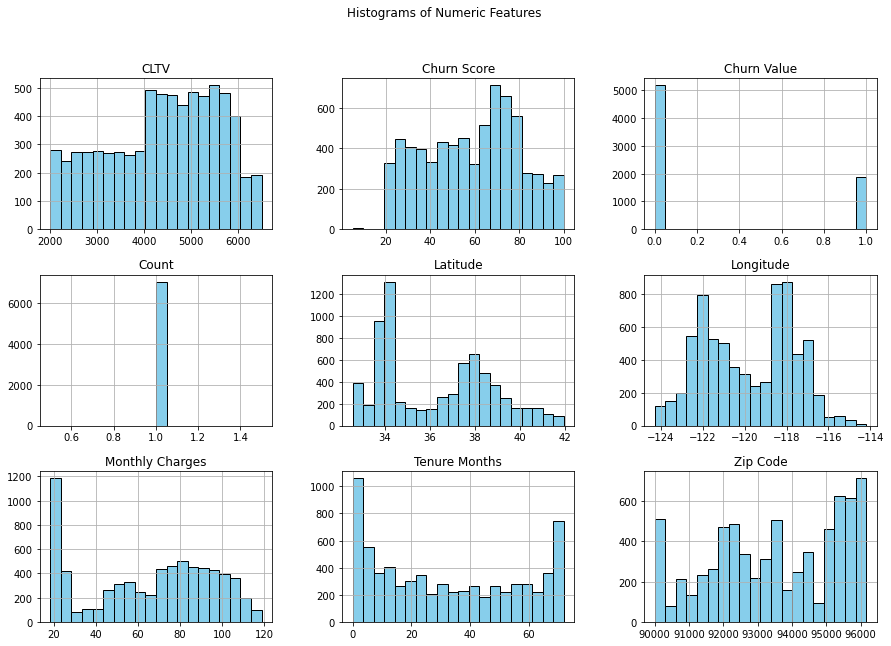

In [52]:
# --- EDA: Histogram Plots ---


numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(bins=20, figsize=(15,10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numeric Features')
plt.show()

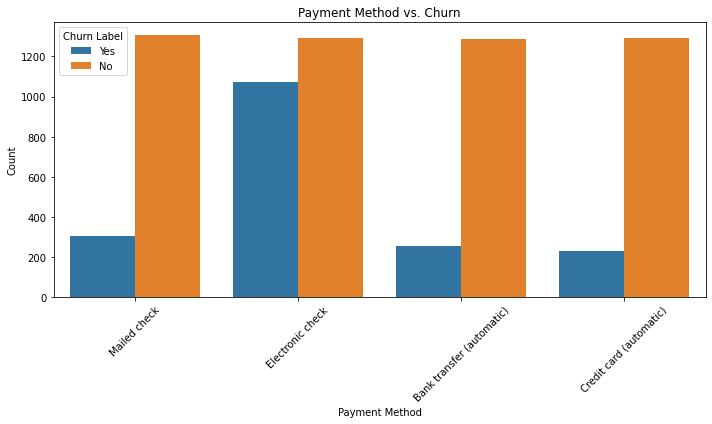

In [56]:
# --- EDA: Plotting Payment Method vs. Churn ---

plt.figure(figsize=(10, 6))
sns.countplot(x='Payment Method', hue='Churn Label', data=df)
plt.title('Payment Method vs. Churn')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

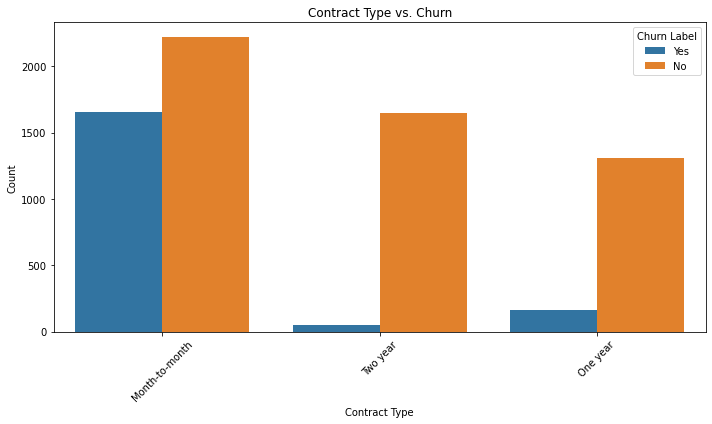

In [11]:
# --- EDA: Plotting Contract Type vs. Churn ---

plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn Label', data=df)
plt.title('Contract Type vs. Churn')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Feature Engineering

**Data Cleaning:**  
- Removes non-predictive columns (e.g., CustomerID, location details).  
- Converts Total Charges to numeric, imputing missing values with the mean.

**Feature Transformation:**  
- Encodes categorical variables (e.g., Contract) using label encoding.  
- Creates a new feature, NumServices, by counting active services.

**Preprocessing:**  
- Splits data into training and test sets.  
- Applies standard scaling to ensure consistent feature ranges.

In [18]:

from sklearn.model_selection import train_test_split


In [79]:
# --- FE: Identify Irrelevant or Redundant Columns ---
# Columns to drop:
# - CustomerID & Count: unique identifiers that don't help prediction.
# - Location details: Country, State, City, Zip Code, Lat Long
# - Churn Reason: 1:1 in this dataset with churned customers. This is direct leakage and must be removed. 

drop_cols = ['CustomerID', 'Churn Label', 'Count', 'Country', 'State', 'Zip Code', 'Lat Long', 'City', 'Churn Reason']

df_reduced = df.drop(columns=[col for col in drop_cols if col in df.columns])

In [80]:
# --- FE: Encoding Contract Types ---
le=LabelEncoder()
df_reduced ['Contract']=le.fit_transform(df_reduced ['Contract'])

In [81]:
# --- FE: Convert Charges to floats (originally strings) ---
df_reduced['Total Charges']=pd.to_numeric(df_reduced['Total Charges'],errors='coerce')
df_reduced['Total Charges'].fillna(df_reduced['Total Charges'].mean(),inplace=True)

In [82]:
# --- FE: Calculate # of services per customer  ---
# hypothesis: more services may be inversely correlated with churn 
service_cols = [
    'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup',
    'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies'
]


df_reduced['NumServices'] = df_reduced[service_cols].apply(lambda row: (row == "Yes").sum(), axis=1)


In [83]:
# --- FE: Impute categorical data ---
df_reduced=pd.get_dummies(df_reduced,drop_first=True)
df_reduced.head()

Latitude   Longitude  Tenure Months  Contract  Monthly Charges  \
0  33.964131 -118.272783              2         0            53.85   
1  34.059281 -118.307420              2         0            70.70   
2  34.048013 -118.293953              8         0            99.65   
3  34.062125 -118.315709             28         0           104.80   
4  34.039224 -118.266293             49         0           103.70   

   Total Charges  Churn Value  Churn Score  CLTV  NumServices  ...  \
0         108.15            1           86  3239            3  ...   
1         151.65            1           67  2701            1  ...   
2         820.50            1           86  5372            5  ...   
3        3046.05            1           84  5003            6  ...   
4        5036.30            1           89  5340            6  ...   

   Tech Support_No internet service  Tech Support_Yes  \
0                                 0                 0   
1                                 0                 0   
2                                 0                 0   
3                                 0                 1   
4                                 0                 0   

   Streaming TV_No internet service  Streaming TV_Yes  \
0                                 0                 0   
1                                 0                 0   
2                                 0                 1   
3                                 0                 1   
4                                 0                 1   

   Streaming Movies_No internet service  Streaming Movies_Yes  \
0                                     0                     0   
1                                     0                     0   
2                                     0                     1   
3                                     0                     1   
4                                     0                     1   

   Paperless Billing_Yes  Payment Method_Credit card (automatic)  \
0                      1                                       0   
1                      1                                       0   
2                      1                                       0   
3                      1                                       0   
4                      1                                       0   

   Payment Method_Electronic check  Payment Method_Mailed check  
0                                0                            1  
1                                1                            0  
2                                1                            0  
3                                1                            0  
4                                0                            0  

[5 rows x 35 columns]

In [84]:
# --- FE: Split data into train | test ---
# Map churn labels to binary values and split the dataset
X = df_reduced.drop(columns=["Churn Value"], axis = 1).values
y = df_reduced["Churn Value"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [85]:
# --- FE: Scale Features  ---
# we do this AFTER splitting so we don't scale across the whole set, risk of leaking 
sd=StandardScaler()
train_X=sd.fit_transform(train_X)
test_X=sd.transform(test_X)

## Modeling

**Model Selection:**  
- Implements Logistic Regression (baseline), Random Forest, and XGBoost.  
- Evaluates models using precision, recall, f1-score, and ROC AUC.

**Performance:**  
- Logistic Regression provides a starting point.  
- Ensemble and boosting techniques (RF and XGBoost) improved prediction accuracy.
- XGBoost has the highest ROC AUC Score, and also provides a good balance of precision and recall
- Particularly for churn modeling, recall is important as we want to capture more of the actual churning population. 


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [86]:
# --- Model: Logistic Regression ---
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_lr))
print("\n" + "="*50 + "\n")


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1055
           1       0.75      0.92      0.83       354

    accuracy                           0.90      1409
   macro avg       0.86      0.91      0.88      1409
weighted avg       0.92      0.90      0.91      1409

Confusion Matrix:
 [[947 108]
 [ 27 327]]
ROC AUC Score: 0.971253380458939




In [87]:
# --- Model: Random Forest ---
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))
print("\n" + "="*50 + "\n")

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1055
           1       0.86      0.84      0.85       354

    accuracy                           0.92      1409
   macro avg       0.90      0.90      0.90      1409
weighted avg       0.92      0.92      0.92      1409

Confusion Matrix:
 [[1006   49]
 [  57  297]]
ROC AUC Score: 0.9725024767718959




In [88]:
# --- Model: XGBoost ---
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1055
           1       0.85      0.82      0.84       354

    accuracy                           0.92      1409
   macro avg       0.90      0.89      0.89      1409
weighted avg       0.92      0.92      0.92      1409

Confusion Matrix:
 [[1003   52]
 [  62  292]]
ROC AUC Score: 0.9804910702332181


# Review Feature Importance

**Analysis:**  
- Uses Random Forest and XGBoost to assess feature contributions.  
- Visualizes logistic regression coefficients for additional interpretability.

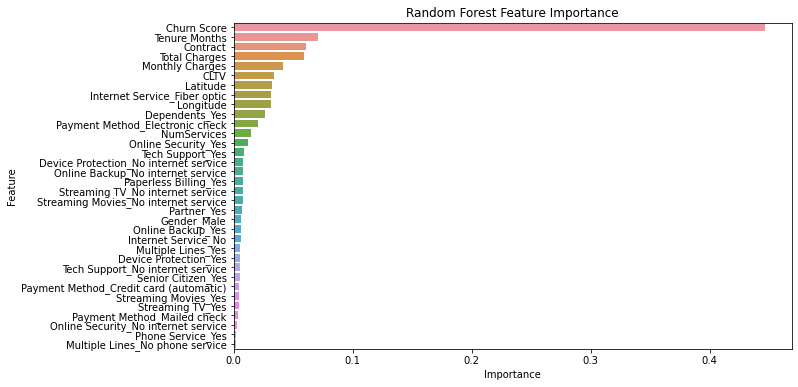

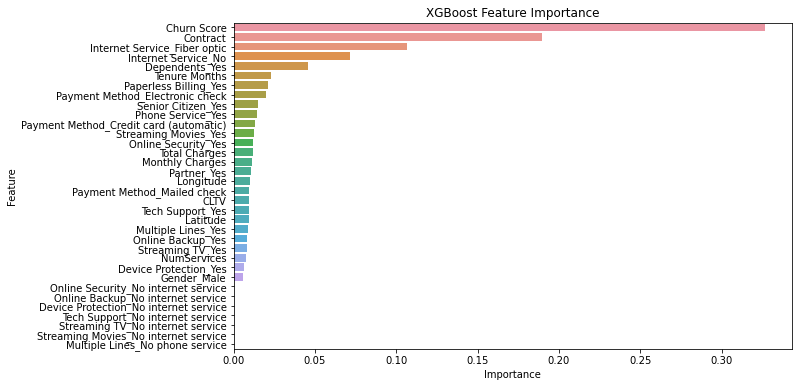

In [89]:

# Convert back to DF for plotting
X_train = pd.DataFrame(X_train, columns=df_reduced.drop(columns=["Churn Value"]).columns)


# For Random Forest:
rf_importances = rf.feature_importances_
features = X_train.columns
rf_importance_df = pd.DataFrame({'Feature': features, 'Importance': rf_importances})
rf_importance_df = rf_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df)
plt.title("Random Forest Feature Importance")
plt.show()

# For XGBoost:
xgb_importances = xgb_clf.feature_importances_
xgb_importance_df = pd.DataFrame({'Feature': features, 'Importance': xgb_importances})
xgb_importance_df = xgb_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df)
plt.title("XGBoost Feature Importance")
plt.show()


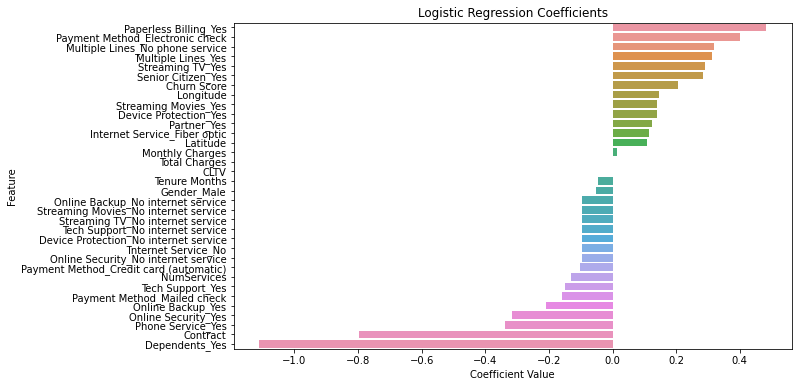

In [90]:
# Get the absolute value of coefficients to rank feature importance
lr_coef = pd.Series(lr.coef_[0], index=X_train.columns)
lr_coef = lr_coef.sort_values( ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=lr_coef.values, y=lr_coef.index)
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()


# Hyperparameter tuning for XGBoost


**Optimization:**  
- Conducts grid search with 5-fold cross-validation.  
- Tunes n_estimators, learning_rate, and max_depth to maximize ROC AUC.  
- Identifies optimal parameters to further boost model performance.

In [91]:
from sklearn.model_selection import GridSearchCV

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(xgb_clf, param_grid, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best AUC score:", grid_search.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  4.6min finished


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best AUC score: 0.9845056067144542


In [94]:
best_params = grid_search.best_params_  

xgb_final = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric="auc")
xgb_final.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_final.predict(X_test)

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_final.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1055
           1       0.85      0.86      0.86       354

    accuracy                           0.93      1409
   macro avg       0.90      0.91      0.91      1409
weighted avg       0.93      0.93      0.93      1409

ROC AUC Score: 0.9822060674217475


# Final Thoughts


**Summary:**  
- The notebook covers a full cycle from exploratory data analysis to modeling and hyperparameter tuning.  
- Key steps include data cleaning, feature engineering, model evaluation, and optimization.

**Key Considerations**
- is it okay to use a derived feature? Churn Score is a feature that saw 66% correlation with churn and significantly boosted performance. Yes, typically it's okay to use other model outputs IF we know how it's derived and investigate the collinearity. 
- is it okay to use churn reason? For modeling, No. This was provided in the data set for every churned customer. While it's useful for hypothesis building and understanding what leads to churn, it's direct leakage with the target.


**Next Steps:**  
- Implement SMOTE to improve model accuracy. The churn rate was 25% in this data set, not drastic enough to require resampling.
- Understand Churn Score inputs. As this is a derived field, it would be good to know which features went into it. 
- Experiment with additional data transformations and external data sources.  

